In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model

In [2]:
def preprocess(image):
    """Normalizes the image and reshapes it into batches."""
    image = image.astype("float32") / 255.0
    image = image.reshape((-1, 28, 28, 1))
    return image

def noise(image):
    """Adds random noise to each image."""
    noise_factor = 0.4
    noisy_image = image + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=image.shape
    )

    return np.clip(noisy_image, 0.0, 1.0)


def display(array1, array2, n = 10):
    """Displays N random images from each array."""
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

(60000, 28, 28)
(60000, 28, 28, 1)


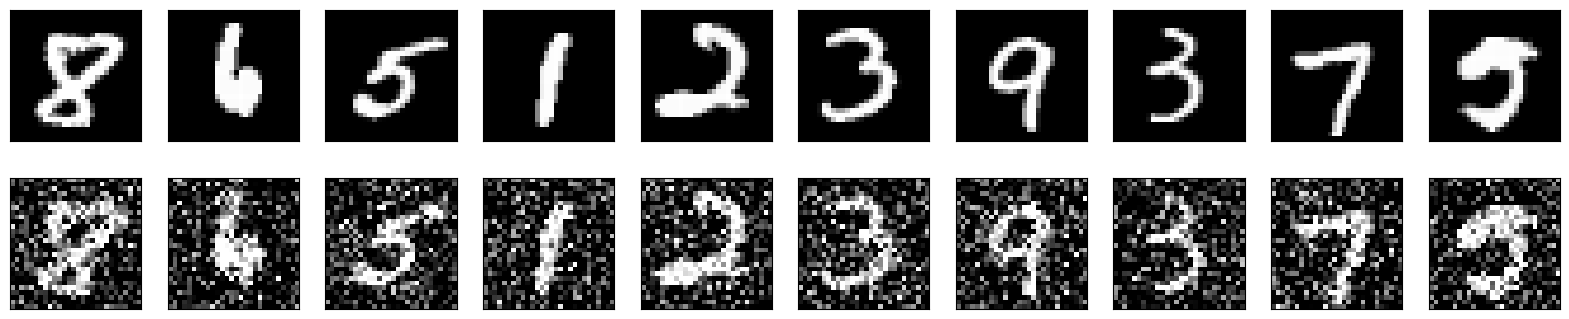

In [3]:
# Preprocess the data
# Load the mnist dataset
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
print(train_data.shape)
train_data = preprocess(train_data)
print(train_data.shape)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [4]:
# Build the autoencoder
inputs = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

In [5]:
# Train the auto-encoder
# Train it using the noisy data as our input and the clean data as our target. 
# We want our autoencoder to learn how to denoise the images.
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 16s 33ms/step - loss: 0.1839 - val_loss: 0.1060
Epoch 2/100
469/469 [==============================] - 15s 32ms/step - loss: 0.1017 - val_loss: 0.0976
Epoch 3/100
469/469 [==============================] - 16s 33ms/step - loss: 0.0962 - val_loss: 0.0946
Epoch 4/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0938 - val_loss: 0.0923
Epoch 5/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0922 - val_loss: 0.0909
Epoch 6/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0910 - val_loss: 0.0899
Epoch 7/100
469/469 [==============================] - 16s 34ms/step - loss: 0.0902 - val_loss: 0.0893
Epoch 8/100
469/469 [==============================] - 16s 33ms/step - loss: 0.0896 - val_loss: 0.0888
Epoch 9/100
469/469 [==============================] - 15s 32ms/step - loss: 0.0890 - val_loss: 0.0882
Epoch 10/100
469/469 [==============================] - 15s 33ms/step - l

313/313 [==============================] - 2s 5ms/step


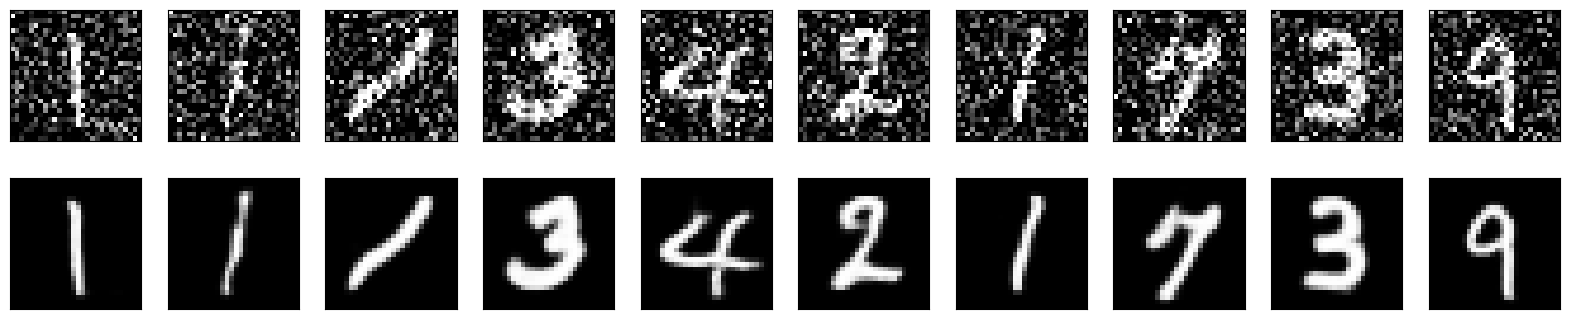

In [6]:
# Predict / Denoise
predictions = autoencoder.predict(noisy_test_data)
# Show results
display(noisy_test_data, predictions)